In [2]:
#loading default python modules used for data exploration/modeling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pyproj import Geod

%matplotlib inline
plt.style.use('seaborn-darkgrid')

/var/folders/tr/f5y3jzgj4_n5l6xfgj36xxnm0000gn/T/ipykernel_10265/2165905523.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


The dataset we are looking at contains 5.5 million rows meaning reading all the data would require a lot of memory. I limited the number of rows while exploring the dataset to allow for faster computation and less memory usage.

In [3]:
%%time 
#convert csv file into dataframe

df_train = pd.read_csv('train.csv', nrows=1000000, parse_dates=['pickup_datetime'])
df_train.head()

CPU times: user 32.9 s, sys: 172 ms, total: 33.1 s
Wall time: 33.1 s


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
#check statistics of the features to perform data cleaning
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


## Data Cleaning

Upon examining the dataset, several inconsistencies were identified. Firstly, a negative fare amount is not a realistic scenario as the fare is the amount paid by the passenger for the ride and cannot be negative. Therefore, any records with negative fare amounts should be removed from the dataset.

Additionally, the dataset contains minimum and maximum coordinates that seem to be further off than the mean coordinates. These records may represent outliers or errors and should also be removed from the dataset.

Furthermore, it was observed that the minimum number of passengers is 0, which implies that there are records in the dataset where the number of passengers is 0. However, this is not possible as a ride requires at least one passenger. Therefore, records with 0 passengers should also be removed from the dataset.

In [5]:
df_train = df_train[df_train.fare_amount > 0] #ensure there were fares in each ride)
df_train = df_train[df_train.passenger_count > 0] #ensure atleast 1 passenger in each ride

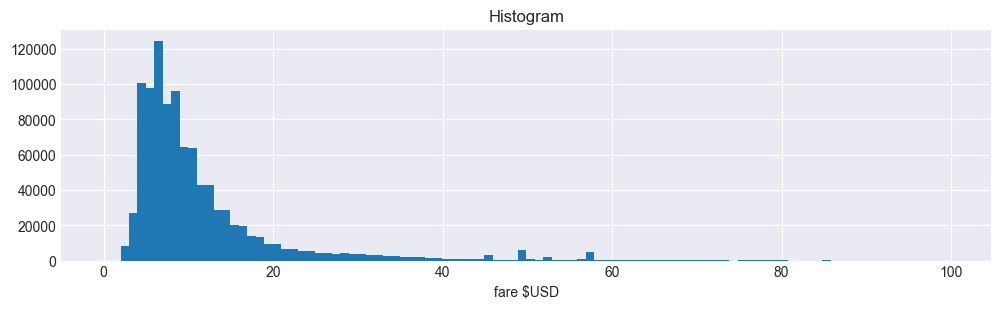

In [6]:
df_train[df_train.fare_amount<100].fare_amount.hist(bins=100, figsize=(12,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

Upon analyzing the histogram of the fare_amount variable, it appears that the central tendency of the fares lies within the range of $10$ to $11$. However, there are intermittent "mini spikes" observed in the range of $40$ to $80$, which could indicate that these trips were pre-arranged and have a fixed fare.

These "mini spikes" may be attributed to longer trips with a fixed price, such as airport transfers or out-of-town rides. This suggests that the dataset contains a mix of standard rides with metered fares as well as pre-arranged rides with fixed fares, which should be taken into account during any analysis of the fare data.

In [7]:
len(df_train)

996368

## Displaying Location Data

Visualizing the location data on a map can provide a more insightful representation of the data and its correlation with the taxi fares.

As the dataset pertains to New York City, the coordinates for the city are 40.7128 N and 74.006 W. These coordinates serve as the central point for the city and can be used as a reference for plotting the location data.

To define a box within which the test set operates, we need to determine the minimum and maximum values for both the latitude and longitude coordinates in the test set. This will allow us to set the bounds of the box and plot only the data points that fall within this range.

Once we have the minimum and maximum values for both latitude and longitude, we can define the boundaries of the box by creating a rectangular region around the test set data points. This will enable us to focus on the relevant portion of the map and ensure that the plotted data points are clearly visible and accurately represented.

In [7]:
df_test = pd.read_csv('test.csv', parse_dates=['pickup_datetime'] )
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1


In [8]:
# minimum and maximum longitude test

min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [9]:
# minimum and maximum latitude test

min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [10]:
#select points that fall inside boundaries
def select_within_box(df, box):
    return (df.pickup_longitude >= box[0]) & (df.pickup_longitude <= box[1]) & \
        (df.pickup_latitude >= box[2]) & (df.pickup_latitude <= box[3]) & \
        (df.dropoff_longitude >= box[0]) & (df.dropoff_longitude <= box[1]) & \
        (df.dropoff_latitude >= box[2]) & (df.dropoff_latitude <= box[3])

box = (-74.5, -72.8, 40.5, 41.8)
#nyc map
nyc_map = plt.imread('map.png')

In [12]:
#remove points which aren't a part of testing longitude and latitudes. 

df_train = df_train[select_within_box(df_train,box)]
len(df_train)

975512

In [13]:
def plot_on_map(df, box, nyc_map, s=10, alpha=.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10)) #creates figure with two subplots side by side
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    #plots the pickup locations on the first subplot,c = color, zorder specifies scatter points should be plotted
    #above the map image
    axs[0].set_xlim((box[0], box[1])) #min/max longitude values
    axs[0].set_ylim((box[2], box[3])) #min/max latitude values
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=box)
    
    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((box[0], box[1]))
    axs[1].set_ylim((box[2], box[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=box)

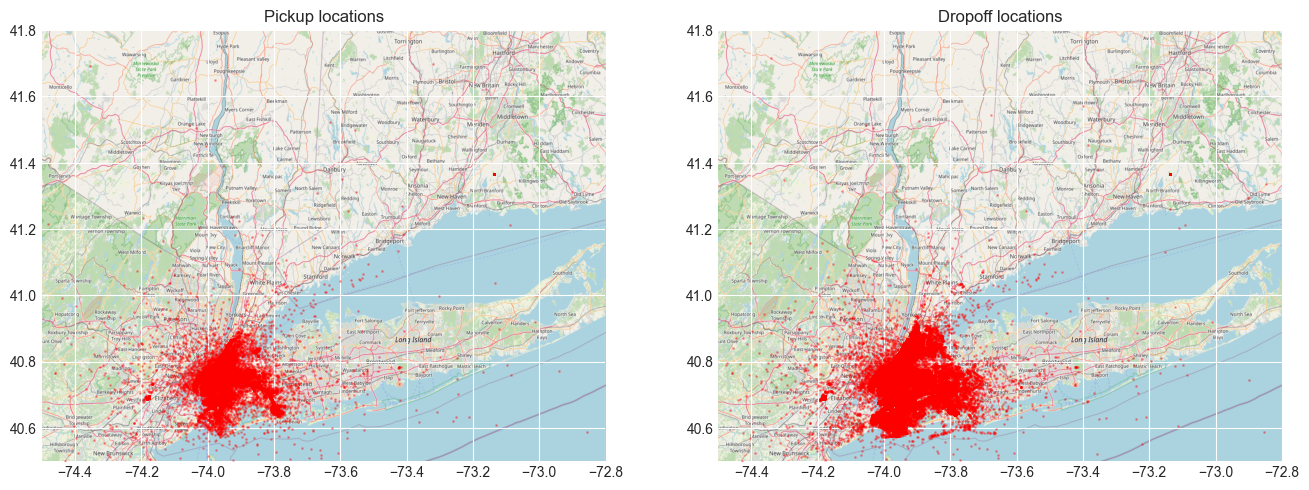

In [14]:
#plot training data on map
plot_on_map(df_train, box, nyc_map, s=1, alpha=.3)

## Testing Baseline Models

It is expected that there is a strong correlation between the location and the taxi fares, given that fares in different areas of New York City may vary significantly. As the standard deviation of the fare amounts in the dataset is currently $9.82, it is reasonable to expect that any predictive models developed should be able to outperform this baseline level of accuracy.

In other words, the models should be able to capture the underlying patterns in the location and fare data and produce fare predictions that are more precise than the variation in fares observed in the dataset. By achieving this, we can ensure that the models provide meaningful insights into the relationship between location and fares and can be used to make accurate fare predictions for future taxi rides. 

In [79]:
def get_split_sets(train):
    x = train.drop(columns=['fare_amount', 'key']) #'pickup_datetime for baseline models'
    y = train['fare_amount'].values
    x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=.1, random_state=0)
    return x_train, x_val, y_train, y_val

def lin_model(x_train, x_val, y_train, y_val):
    model = LinearRegression()
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred

def knn_model(x_train, x_val, y_train, y_val, neighbors):
    min_rmse = 1000
    for n in neighbors:
        knn = KNeighborsRegressor(n_neighbors=n)
        knn.fit(x_train, y_train)
        pred = knn.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        if rmse < min_rmse:
            min_rmse = rmse
            model = knn
            best_pred = pred
        print('Neighbours', n, 'RMSE', rmse)
    return model, min_rmse, best_pred

def xgb_model(params, x_train, x_val, y_train, y_val):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=100)
    pred = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred

In [17]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [19]:
#Baseline Linear Regression Model

x_train, x_val, y_train, y_val = get_split_sets(df_train)
lin_init_model, lin_rmse, lin_pred = lin_model(x_train, x_val, y_train, y_val) 

In [20]:
#Baseline KNeighbors Model

k_choices = [10,20,30,40,50,60]
knn_init_model, knn_rmse, knn_pred = knn_model(x_train, x_val, y_train, y_val, k_choices)

Neighbours 10 RMSE 4.16995976205552
Neighbours 20 RMSE 4.132463966143876
Neighbours 30 RMSE 4.178260006130131
Neighbours 40 RMSE 4.209053521813229
Neighbours 50 RMSE 4.244539718479308
Neighbours 60 RMSE 4.276729942214103


In [21]:
#Baseline XGBoost Model

params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'eta': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}
xg_init_model, xg_rmse, xg_pred = xgb_model(params, x_train, x_val, y_train, y_val)

[0]	eval-rmse:13.63997
[100]	eval-rmse:4.56723
[200]	eval-rmse:4.41492
[244]	eval-rmse:4.40039


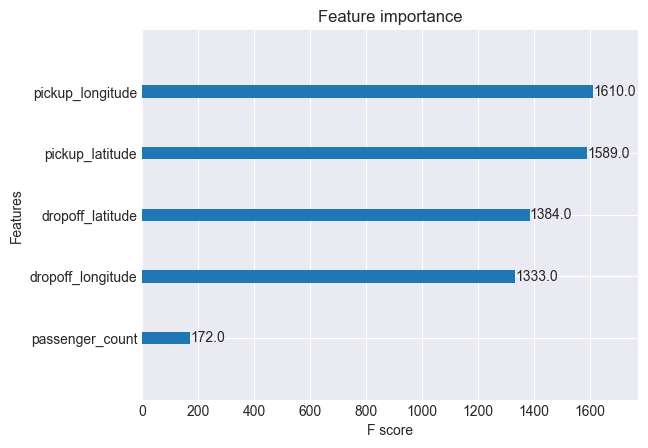

In [24]:
xgb.plot_importance(xg_init_model); #observing which features have the most importance for the model

In [23]:
print('Linear Regression RMSE: ', lin_rmse)
print('KNN RMSE:               ', knn_rmse)
print('XGBoost RMSE:           ', xg_rmse)

Linear Regression RMSE:  8.393503394058051
KNN RMSE:                4.132463966143876
XGBoost RMSE:            4.400386833940826


Among the regression models that we have tested, linear regression has performed the poorest in terms of RMSE (Root Mean Squared Error), indicating that it may not be the best choice for accurately predicting taxi fares based on the given features.

On the other hand, KNN regression has demonstrated the best RMSE so far, implying that it may be a suitable model for this problem. Additionally, XGBoost has shown promising results and is not far behind KNN regression in terms of performance. Overall, these findings suggest that KNN regression and XGBoost may be the better models to use for predicting taxi fares in our dataset.

## Feature Creation and Exploration

__Created Features__
- __Distance__: This feature calculates the great-circle distance between the pickup and dropoff locations, which is a strong predictor of taxi fares.
- __Weekday__: This feature extracts the day of the week from the pickup date and time, which can capture the temporal variation in taxi demand and traffic patterns.
- __Time__: This feature extracts the time of day from the pickup date and time, which can capture the temporal variation in taxi demand and traffic patterns.
- __Distances to Nearby Airports__: This feature calculates the distance between the pickup and dropoff locations and the three major airports in the New York City area, which may capture the demand for taxi rides to and from airports.
- __Distance from Reduce Fare Area__: This feature calculates the distance between the pickup location and the Reduced Fare area we discover.

In [25]:
%%time 

#load additional rows for data exploration
explore_df = pd.read_csv('train.csv', nrows=5000000, parse_dates=['pickup_datetime'])

CPU times: user 2min 44s, sys: 1.1 s, total: 2min 46s
Wall time: 2min 46s


In [39]:
explore_df = explore_df[explore_df.fare_amount > 0] #ensure there were fares in each ride)
explore_df = explore_df[(explore_df.passenger_count > 0) & (explore_df.passenger_count <= 6)] #ensure atleast 1 passenger in each ride
explore_df = explore_df[select_within_box(explore_df,box)] #ensure inside test csv boundaries

In [40]:
def distance(lon_one, lat_one, lon_two, lat_two): #creating distance feature in miles
    az12, az21, dist = Geod(ellps='WGS84').inv(lon_one, lat_one, lon_two, lat_two)
    return [d/1609.34 for d in dist]

In [46]:
def shared_features(df): #features used in data exploration and final model
    rows = len(df)
    pickup_long = df.pickup_longitude.tolist()
    pickup_lat = df.pickup_latitude.tolist()
    dropoff_long = df.dropoff_longitude.tolist()
    dropoff_lat = df.dropoff_latitude.tolist()
    
    jfk_long, jfk_lat = [-73.785937]*rows, [40.645494]*rows #airport values
    lga_long, lga_lat = [-73.872067]*rows, [40.774071]*rows
    nla_long, nla_lat = [-74.177721]*rows, [40.690764]*rows
    
    exp_long, exp_lat = [-73.137393]*rows, [41.366138]*rows #
    
    df = df.assign( #assign new features
        distance=distance(pickup_long, pickup_lat, dropoff_long, dropoff_lat),
        weekday = df.pickup_datetime.dt.dayofweek,
        dayofyear=df.pickup_datetime.dt.dayofyear,
        time=(df.pickup_datetime.dt.hour),
        pickup_dist_jfk=pd.Series(distance(pickup_long, pickup_lat, jfk_long, jfk_lat)),
        dropoff_dist_jfk=pd.Series(distance(dropoff_long, dropoff_lat, jfk_long, jfk_lat)),
        pickup_dist_lga=pd.Series(distance(pickup_long, pickup_lat, lga_long, lga_lat)),
        dropoff_dist_lga=pd.Series(distance(dropoff_long, dropoff_lat, lga_long, lga_lat)),
        pickup_dist_nla=pd.Series(distance(pickup_long, pickup_lat, nla_long, nla_lat)),
        dropoff_dist_nla=pd.Series(distance(dropoff_long, dropoff_lat, nla_long, nla_lat)),
        pickup_dist_exp=pd.Series(distance(pickup_long, pickup_lat, exp_long, exp_lat)),
        dropoff_dist_exp=pd.Series(distance(dropoff_long, dropoff_lat, exp_long, exp_lat)))
    
    return df

In [68]:
def airport_feature(df): #to create airport proximity box plot
    df.loc[((df['pickup_dist_jfk']<1) | (df['dropoff_dist_jfk']<1)), 'close_to_airport'] = 'JFK'
    df.loc[((df['pickup_dist_lga']<1) | (df['dropoff_dist_lga']<1)), 'close_to_airport'] = 'LaGuardia'
    df.loc[((df['pickup_dist_nla']<1) | (df['dropoff_dist_nla']<1)), 'close_to_airport'] = 'Newark'
    
    return df

In [48]:
explore_df = shared_features(explore_df)
explore_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,weekday,...,time,pickup_dist_jfk,dropoff_dist_jfk,pickup_dist_lga,dropoff_dist_lga,pickup_dist_nla,dropoff_dist_nla,close_to_airport,pickup_dist_exp,dropoff_dist_exp
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.639766,0,...,17,6.064398,5.457950,3.920652,4.553652,17.634137,17.712987,NaN,57.826671,58.220380
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.246524,1,...,16,12.913086,13.847967,8.709680,5.649734,8.607701,12.171053,NaN,64.416141,59.645084
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863169,3,...,0,13.062352,12.992832,5.872878,6.459716,11.333050,10.624047,NaN,60.757698,61.591085
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.737227,5,...,4,12.175760,13.303115,6.665610,6.365630,10.425718,10.820521,NaN,62.277017,61.244407
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.241713,1,...,7,12.765517,13.090831,5.054952,4.487055,12.226728,13.259247,NaN,59.881256,58.696609


In [69]:
explore_df = airport_feature(explore_df)
explore_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,weekday,...,time,pickup_dist_jfk,dropoff_dist_jfk,pickup_dist_lga,dropoff_dist_lga,pickup_dist_nla,dropoff_dist_nla,close_to_airport,pickup_dist_exp,dropoff_dist_exp
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.639766,0,...,17,6.064398,5.457950,3.920652,4.553652,17.634137,17.712987,No,57.826671,58.220380
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.246524,1,...,16,12.913086,13.847967,8.709680,5.649734,8.607701,12.171053,No,64.416141,59.645084
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863169,3,...,0,13.062352,12.992832,5.872878,6.459716,11.333050,10.624047,No,60.757698,61.591085
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.737227,5,...,4,12.175760,13.303115,6.665610,6.365630,10.425718,10.820521,No,62.277017,61.244407
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.241713,1,...,7,12.765517,13.090831,5.054952,4.487055,12.226728,13.259247,No,59.881256,58.696609


In [70]:
len(explore_df)

4876377

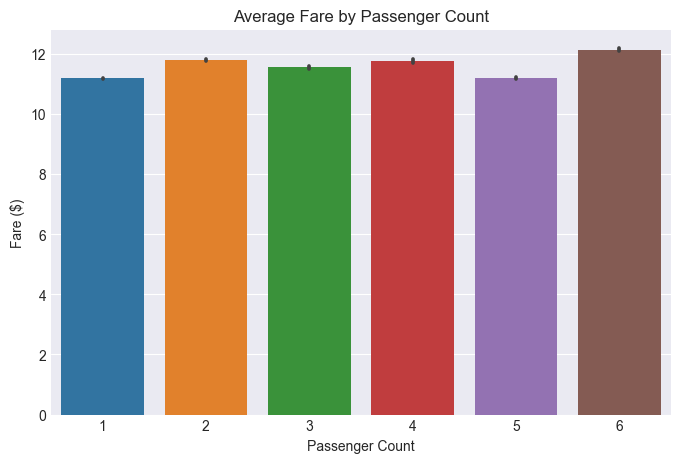

In [51]:
plt.figure(figsize=(8, 5))
sns.barplot(x='passenger_count', y='fare_amount', data=explore_df)
plt.xlabel('Passenger Count')
plt.ylabel('Fare ($)')
plt.title('Average Fare by Passenger Count')
plt.show()

Our analysis indicates that there is no significant correlation between the number of passengers and the fare amount for taxi rides, as the fares remain consistent regardless of the passenger count.

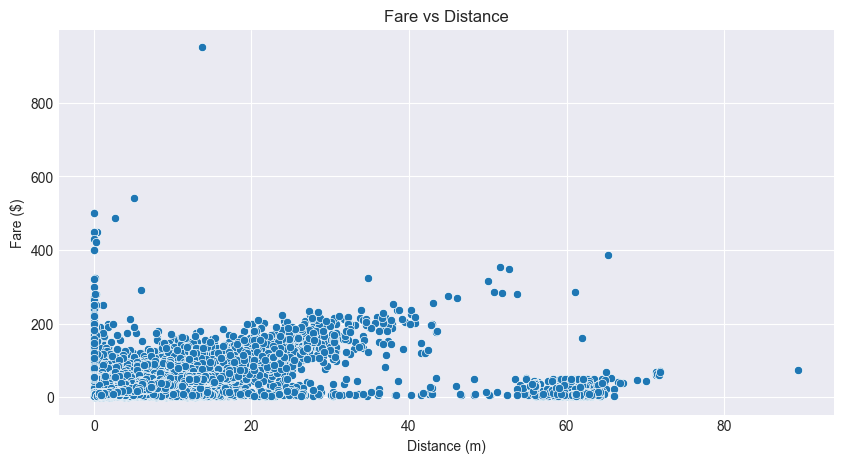

In [52]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(x='distance', y='fare_amount', data=explore_df).set_title('Fare vs Distance')
plt.xlabel('Distance (m)')
plt.ylabel('Fare ($)');

Our analysis of the relationship between distance and fare reveals a positive correlation, with the fares generally increasing as the distance covered by the ride increases. However, there are some outliers present in both the distance and fare variables that are cause for concern.

For instance, some rides with very short distances have surprisingly high fares, while some longer rides have unexpectedly low fares. These anomalies could be attributed to various factors, such as fixed fares for certain routes, traffic congestion or inaccurate data.

Furthermore, we observed that rides that cover distances beyond 40 miles have an average fare of around $30, which is an unexpected finding. Possible explanations for this could include fixed fares for longer trips or traffic patterns that affect fares for longer distances. Overall, it is important to carefully consider the data points with extreme values and explore potential explanations for any unusual patterns observed.

**Observing trips over 40 miles VS less then 40 miles**

In [35]:
print('Average fare for distance over 40 miles:', explore_df[explore_df.distance > 40].fare_amount.mean())
print('Average fare for distance 20-40 miles  :', explore_df.query('20 < distance < 40').fare_amount.mean())

Average fare for distance over 40 miles: 23.614046997389035
Average fare for distance 20-40 miles  : 106.2660078023407


In [36]:
long_trips = explore_df[explore_df.distance > 40].fare_amount.count()
print(long_trips, 'trips over 40m.')

766 trips over 40m.


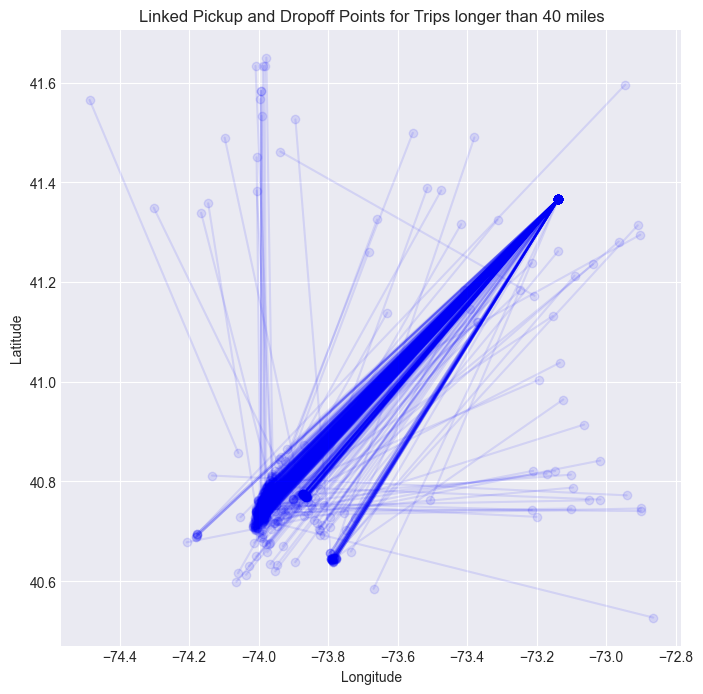

In [53]:
def plot_long_trips(df):
    rows=len(df)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for i in range(rows):
        plt.plot([df.pickup_longitude[i],df.dropoff_longitude[i]], [df.pickup_latitude[i], df.dropoff_latitude[i]], marker='o', color='b', alpha=0.1)
    plt.title('Linked Pickup and Dropoff Points for Trips longer than 40 miles')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()    

plot_long_trips(explore_df[explore_df.distance>40].reset_index())

Our analysis indicates the presence of a distinct location that is associated with long-distance trips. To identify this location and investigate the fares associated with it, further exploration of the data is necessary.

In [54]:
print(explore_df[explore_df.distance>40].query(
    '41.36 < pickup_latitude < 41.37 or 41.36 < dropoff_latitude < 41.37').fare_amount.count(), 
      f'of the {long_trips} with distance > 40 miles start or end this area')
print(f'The average fare of these trips is', explore_df[explore_df.distance>40].query(
    '41.36 < pickup_latitude < 41.37 or 41.36 < dropoff_latitude < 41.37').fare_amount.mean())
print(f'The average fare of long trips starting and ending elsewhere is', explore_df[explore_df.distance>40].query
      ('(41.36 > pickup_latitude or pickup_latitude > 41.37) and (41.36 > dropoff_latitude or dropoff_latitude > 41.37)')
      .fare_amount.mean())

705 of the 766 with distance > 40 miles start or end this area
The average fare of these trips is 16.54201418439716
The average fare of long trips starting and ending elsewhere is 105.34819672131145


It is difficult to find a clear explanation for this occurring, but what we can do is create a feature for our model that measures distance from this area. 


__We can next look at how time interacts with fares__

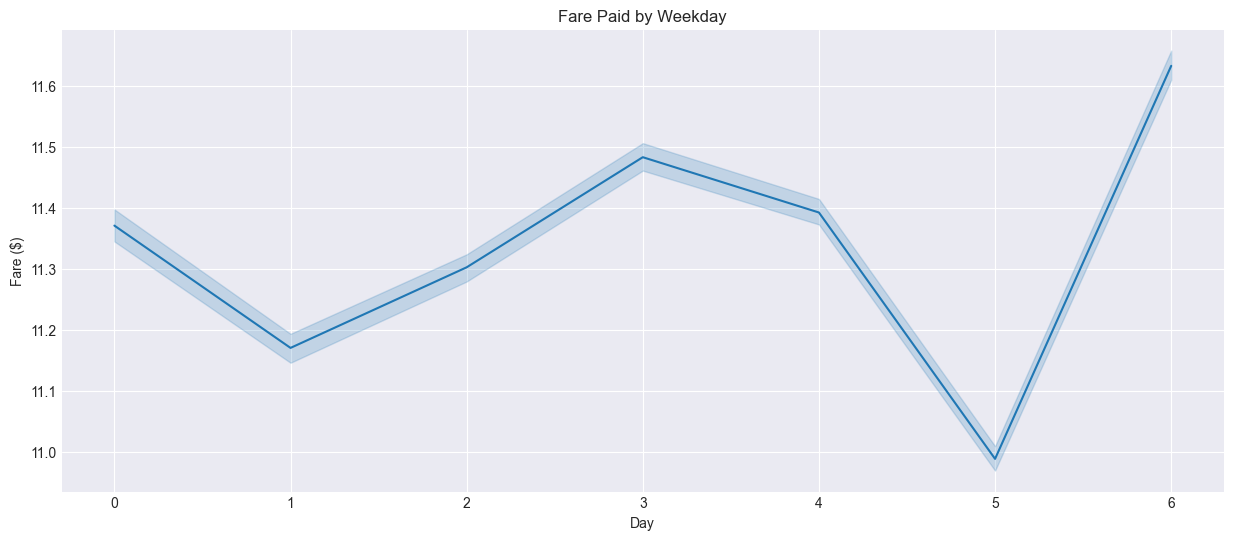

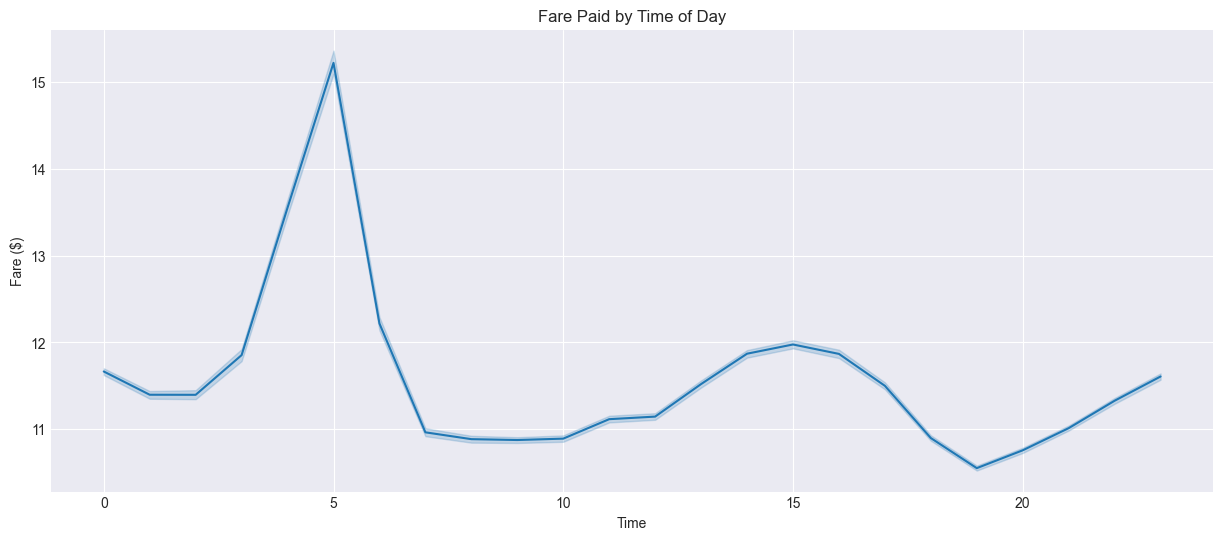

In [56]:
# Plot the fare paid by weekday
plt.figure(figsize=(15,6))
sns.lineplot(data=explore_df, x='weekday', y='fare_amount')
plt.title('Fare Paid by Weekday')
plt.ylabel('Fare ($)')
plt.xlabel('Day')
plt.show()

# Plot the fare paid by time of day
plt.figure(figsize=(15,6))
sns.lineplot(data=explore_df, x='time', y='fare_amount')
plt.title('Fare Paid by Time of Day')
plt.ylabel('Fare ($)')
plt.xlabel('Time')
plt.show()

Upon analyzing the data, we observe that the average taxi fares vary slightly across different days of the week. Notably, Sunday records the highest average fares, while Saturday has the lowest. Despite this variation, the average fares across all days remain relatively similar.

Examining the fares by time of day, we note that the highest fares are typically recorded around 5 AM, which is a time when people may be commuting into the city or when traffic is heavy. This observation aligns with our understanding of traffic patterns and suggests that time of day is an important factor to consider when predicting taxi fares.

Overall, these findings highlight the potential influence of temporal factors on taxi fares and emphasize the need to consider time-related features in developing accurate fare prediction models.

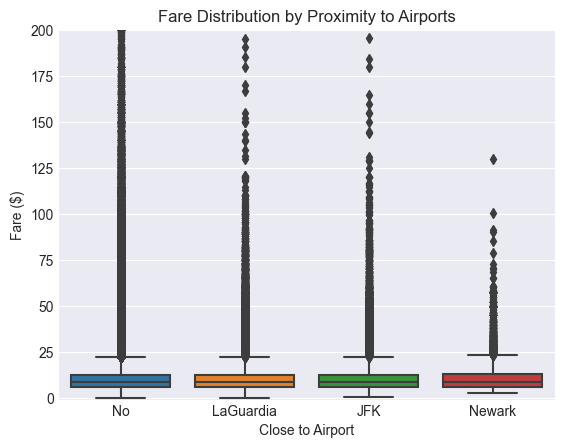

In [71]:
explore_df['close_to_airport'].fillna('No', inplace=True)
sns.boxplot(x=explore_df['close_to_airport'], y=explore_df['fare_amount'])
plt.title('Fare Distribution by Proximity to Airports')
plt.ylim(-1,200)
plt.xlabel('Close to Airport')
plt.ylabel('Fare ($)');

In [67]:
explore_df['close_to_airport'].value_counts()

No           4613187
LaGuardia     157188
JFK            99575
Newark          6427
Name: close_to_airport, dtype: int64

Upon analyzing the distribution of fares in proximity to airports, we observe that there isn't much difference between the fares for trips close to the airports and those that are not. This suggests that proximity to airports may not be a significant factor in determining taxi fares in this dataset.

However, it's important to note that this finding may be specific to this dataset and may not generalize to other locations or time periods. Further analysis and modeling may be required to fully understand the relationship between proximity to airports and taxi fares.

## Final Model

We will use some of the features we created above along with a couple others to improve our model
- __sin, cos(time)__: Encode time of day as a cyclic variable, allowing the model to capture cyclical patterns in taxi demand and traffic.
- __sin, cos(day)__: Encode day of the year as a cyclic variable, allowing the model to capture seasonal patterns in taxi demand and traffic.
- __sin, cos(weekday)__: Encode day of the week as a cyclic variable, allowing the model to capture weekly patterns in taxi demand and traffic.

In [75]:
def modelling_features(df):
    df = shared_features(df)
    df = df[df.fare_amount > 0] #ensure there were fares in each ride)
    df = df[(df.passenger_count > 0) & (df.passenger_count <= 6)] #ensure atleast 1 passenger in each ride
    df = df[select_within_box(df,box)] #ensure inside test csv boundaries
    df = df.assign(
        sin_time=np.sin(2*np.pi*df['time']/24),
        cos_time=np.cos(2*np.pi*df['time']/24),
        sin_dayofyear=np.sin(2*np.pi*df['dayofyear']/365),
        cos_dayofyear=np.cos(2*np.pi*df['dayofyear']/365),
        sin_weekday=np.sin(2*np.pi*df['weekday']/6),
        cos_weekday=np.cos(2*np.pi*df['weekday']/6)).drop(columns=['pickup_datetime', 'time', 'weekday'])
    return df

In [ ]:
#load training set again to upload all new features on
#important to edit modelling_features on test set to comment out df_fare, as testset doesn't contain fare

train = pd.read_csv('train.csv', nrows=1000000, parse_dates=['pickup_datetime'])
train = modelling_features(train)
df_test = modelling_features(df_test)

In [80]:
x_train, x_val, y_train, y_val = get_split_sets(train)
lin_final_model, lin_final_rmse, lin_final_pred = lin_model(x_train, x_val, y_train, y_val)

In [82]:
knn_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
k_choices = [16,20,24,28,32]
knn_final_model, knn_final_rmse, knn_final_pred = knn_model(x_train[knn_cols], x_val[knn_cols], y_train, y_val, k_choices)

Neighbours 16 RMSE 4.047319030676862
Neighbours 20 RMSE 4.034492409698948
Neighbours 24 RMSE 4.037033940152271
Neighbours 28 RMSE 4.0514567360804845
Neighbours 32 RMSE 4.063653490822436


In [83]:
params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'eta': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}
xg_final_model, xg_final_rmse, xg_final_pred = xgb_model(params, x_train, x_val, y_train, y_val)

[0]	eval-rmse:13.34080
[100]	eval-rmse:3.99511
[125]	eval-rmse:3.98049


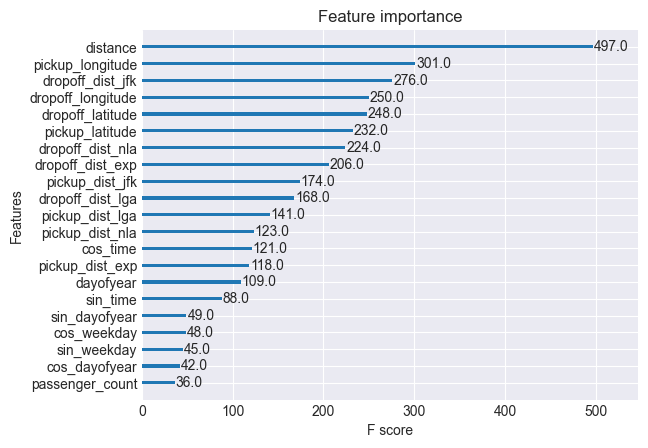

In [84]:
xgb.plot_importance(xg_final_model);

In [85]:
print('Linear Regression RMSE', lin_final_rmse)
print('KNN RMSE', knn_final_rmse)
print('XGBoost RMSE', xg_final_rmse)

Linear Regression RMSE 5.119084719374706
KNN RMSE 4.034492409698948
XGBoost RMSE 3.9799068427489503


After adding the new features, all three models showed improved performance, with the linear regression model showing the most improvement. However, adding the new features to the KNN model actually hurt its performance and slowed down the model, so it was only run using the four original features.

Of particular interest was the XGBoost model, which achieved an RMSE of 3.98 and made the most use of the features distance, longitudes, and distance from JFK.

In [86]:
d = {}
for a in np.linspace(0,1,101):
    final_preds_ave = (xg_final_pred*(1-a) + knn_final_pred * a)
    rmse = np.sqrt(mean_squared_error(y_val, final_preds_ave))
    d[a] = rmse
alpha = min(d, key=d.get)
print('Best weight to give KNN: ', alpha)

Best weight to give KNN:  0.43


In [87]:
x_test = df_test.drop(columns=['key'])

In [88]:
d_test = xgb.DMatrix(x_test)
xgb_test_pred = xg_final_model.predict(d_test)
knn_test_pred = knn_final_model.predict(x_test[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']])

In [90]:
submission_pred = (xgb_test_pred*(1-alpha) + knn_test_pred * alpha)
submission = pd.DataFrame({'key': df_test.key, 'fare_amount': submission_pred})
submission.to_csv('submission.csv', index=False)

This submission of model achieved a RMSE of 3.48 on the test set, showing an extremely low margin of error